# Práctica 2: Modelo cinemático inverso de un manipulador y planteamiento de trayectoria

## Objetivo

El objetivo de esta práctica es que el alumno comprenda, interprete y modifique la información básica de los formatos de Universal Robot Description File (URDF).


### Metas 

- Que el alumno aplique un modelo cinemático inverso para calcular una trayectoria a partir de una posición actual hacia una posición final
- Que el alumno grafique y analice los resultados del modelo

### Contribución al perfil del egresado

La siguiente práctica contribuye en los siguientes puntos al perfil del egresado:

#### Aptitudes y habilidades

- Para modelar, simular e interpretar el comportamiento de los sistemas mecatrónicos.
- Para diseñar, construir, operar y mantener los sistemas mecatrónicos y sus componentes.

#### Actitudes

- Tener confianza en su preparación académica.
- Comprometido con su actualización, superación y competencia profesional.

#### De tipo social

- Promover el cambio en la mentalidad frente a la competitividad internacional.

## Rúbrica de evaluación

La evaluación de la práctica contará de los siguientes puntos y se evaluará con los siguientes criterios:

| Elemento | Porcentaje |
| ------:| -----------:|
| **Cuestionario previo** | 15% | 
| **Desarrollo** | 35% |
| **Análisis de resultados**  | 35% |
| **Conclusiones** | 15% |

<br>


| Elemento | Malo | Regular | Bueno |
| ------:| ------ | --------| ------|
| **Cuestionario previo** | El trabajo no contiene cuestionario previo o todas las preguntas son incorrectas (0%)| Al menos la mitad de las preguntas son correctas (8%) |  Todas las preguntas son correctas (15%) |
| **Desarrollo** | El trabajo no contiene desarrollo o su planteamiento no concuerda con lo deseado (0%) | El desarrollo está mal planteado o no llega a los resultados esperados (10%) | El desarrollo tiene un planteamiento adecuado y llega a los resultados esperados (35%) |
| **Análisis de resultados**  | El trabajo no contiene análisis de resultados o la información no se está interpretando correctamente (0%) | La interpretación de los resultados es parcial o desorganizada (10%) | Realiza un correcto análisis de los resultados de forma organizada   (35%) |
| **Conclusiones** | El trabajo no contiene conclusiones o no hacen referencia al trabajo desarrollado y los objetivos planteados (0%) | La redacción de las conclusiones es desorganizada o confusa (8%) | Las conclusiones del trabajo son claras y hacen referencia al trabajo desarrollado y los objetivos planteados (15%) | 



## Introducción

### Transformaciones homogéneas
Las transformaciones homogéneas permiten hacer el planteamiento del modelo cinemático de un robot, considerando las posiciones y orientaciones de las juntas del robot respecto al sistema de referencia de una junta anterior

Este planteamiento es el **modelo de cinemática directa**, que nos permite obtener la posición y velocidad del efector final de un manipulador en términos de los valores de la posición y velocidad de sus juntas (espacio de trabajo)

A través de este modelo se puede obtener el **modelo de cinemática inversa**, que permite obtener la velocidad de las juntas de un robot a partir de la velocidad deseada del efector final.

### Planteamiento de una trayectoria
Si se conoce el punto inicial y final de una trayectoria deseada, se pueden obtener los puntos intermedios de la trayectoria. La forma más fácil de realizar esta interpolación es a través de un spline. El orden del spline permitirá controlar las condiciones inicial y final de la posición, velocidad ó aceleración que tendrá el efector final durante el trayecto. 

Juntando la interpolación de la trayectoria y el modelo de la cinemática inversa, se pueden obtener todos los puntos intermedios de la trayectoria que deben seguir las juntas del robot para que el efector final siga una trayectoria.

## Cuestionario previo

Responder de forma breve las siguientes preguntas:

- ¿Que son las transformaciones homogéneas?
>Respuesta: Son matrices que combinan rotaciones y traslaciones en una sola representación para describir la posición y orientación de un cuerpo en el espacio.

- ¿Que nos permite obtener el modelo de cinemática directa de un manipulador?
>Respuesta: Nos permite conocer la posición y orientación del efector final a partir de los valores de las articulaciones del manipulador.

- ¿Que nos permite obtener el modelo de cinemática inversa de un manipulador?
>Respuesta: Nos permite calcular los valores de las articulaciones que se requieren para que el efector final alcance una posición y orientación deseadas.

- ¿De que formas se puede interpolar la trayectoria de un efector final entre dos puntos?
>Respuesta: Se puede interpolar mediante trayectorias lineales en el espacio cartesiano o mediante trayectorias articulares en el espacio de las juntas.


## Desarrollo

### 1. Planteamiento de la cinemática directa
En esta primera parte, se crearán las transformaciones homogéneas y el modelo de cinemática directa de un robot RRR, incluyendo la matriz del Jacobiano. Se recomienda usar **Sympy** para el planteamiento de las expresiones. 
Un diagrama del robot se muestra en la imagen:

<img src="imagenes/p2_1.png" alt = "Robot RRR" width="300" height="300" display= "block"/>

** Considerar valores cualesquiera para las dimensiones de los eslabones y la posición inicial de las juntas

In [23]:
# Celda 1: Transformaciones homogéneas, cinemática directa y Jacobiano
from sympy import *
import numpy as np
import matplotlib.pyplot as plt

# Definir dimensiones del robot (0.3 metros para cada eslabón)
L1 = 0.3
L2 = 0.3 
L3 = 0.3

# Definir variables simbólicas para los ángulos de las juntas
theta1, theta2, theta3 = symbols('theta1 theta2 theta3')

# Función para crear transformaciones homogéneas
def matriz_transformacion(x, y, z, roll, pitch, yaw):
    """
    Crea una matriz de transformación homogénea
    x, y, z: traslación
    roll, pitch, yaw: rotaciones en rad (rotación Z-Y-X)
    """
    # Matrices de rotación individuales
    Rz = Matrix([[cos(yaw), -sin(yaw), 0],
                 [sin(yaw),  cos(yaw), 0],
                 [0,         0,        1]])
    
    Ry = Matrix([[cos(pitch),  0, sin(pitch)],
                 [0,           1, 0],
                 [-sin(pitch), 0, cos(pitch)]])
    
    Rx = Matrix([[1, 0,          0],
                 [0, cos(roll), -sin(roll)],
                 [0, sin(roll),  cos(roll)]])
    
    # Rotación combinada (orden: Z-Y-X)
    R = Rz * Ry * Rx
    
    # Vector de traslación
    t = Matrix([[x], [y], [z]])
    
    # Matriz de transformación homogénea 4x4
    T = Matrix.vstack(Matrix.hstack(R, t), Matrix([[0, 0, 0, 1]]))
    
    return T

# Crear matrices de transformación para cada junta
# Junta 1: Rotación en Z, con offset en Z de pi/2 para orientar correctamente
T_0_1 = matriz_transformacion(0, 0, 0, pi/2, 0, theta1)

# Junta 2: Traslación en X (L1) y rotación en Z
T_1_2 = matriz_transformacion(L1, 0, 0, 0, 0, theta2)

# Junta 3: Traslación en X (L2) y rotación en Z
T_2_3 = matriz_transformacion(L2, 0, 0, 0, 0, theta3)

# Efector final: Solo traslación en X (L3)
T_3_e = matriz_transformacion(L3, 0, 0, 0, 0, 0)

# Transformación total desde la base hasta el efector final
T_0_e = simplify(T_0_1 * T_1_2 * T_2_3 * T_3_e)

print("Matriz de transformación homogénea del efector final:")
print(T_0_e)

# Vector de postura del efector final (x, z, orientación)
x_e = T_0_e[0, 3]  # Posición x
z_e = T_0_e[2, 3]  # Posición z
theta_e = theta1 + theta2 + theta3  # Orientación total

# Vector de postura
xi = Matrix([[x_e], [z_e], [theta_e]])
print("\nVector de postura (x, z, θ):")
print(xi)

# Calcular el Jacobiano
# El Jacobiano relaciona las velocidades de las juntas con la velocidad del efector final
# J = [∂xi/∂θ1, ∂xi/∂θ2, ∂xi/∂θ3]
J = Matrix.hstack(diff(xi, theta1), diff(xi, theta2), diff(xi, theta3))

print("\nMatriz Jacobiana:")
print(J)

# Simplificar el Jacobiano
J_simplified = simplify(J)
print("\nJacobiano simplificado:")
print(J_simplified)

# Calcular la inversa del Jacobiano para la cinemática inversa
J_inv = J.inv()
print("\nInversa del Jacobiano:")
print(simplify(J_inv))

# Verificar el modelo con valores específicos
theta_test = [pi/4, pi/4, pi/4]  # Ángulos de prueba
T_test = T_0_e.subs([(theta1, theta_test[0]), (theta2, theta_test[1]), (theta3, theta_test[2])])
xi_test = xi.subs([(theta1, theta_test[0]), (theta2, theta_test[1]), (theta3, theta_test[2])])

print(f"\nEjemplo para θ1={theta_test[0]}, θ2={theta_test[1]}, θ3={theta_test[2]}:")
print(f"Posición del efector: x={float(xi_test[0]):.3f}, z={float(xi_test[1]):.3f}")
print("Orientación del efector: θ={:.3f} rad = {:.1f}°".format(float(xi_test[2]), float(xi_test[2])*180/float(pi)))

Matriz de transformación homogénea del efector final:
Matrix([[cos(theta1)*cos(theta2 + theta3), -sin(theta2 + theta3)*cos(theta1), sin(theta1), 0.3*(cos(theta2) + cos(theta2 + theta3) + 1)*cos(theta1)], [sin(theta1)*cos(theta2 + theta3), -sin(theta1)*sin(theta2 + theta3), -cos(theta1), 0.3*(cos(theta2) + cos(theta2 + theta3) + 1)*sin(theta1)], [sin(theta2 + theta3), cos(theta2 + theta3), 0, 0.3*sin(theta2) + 0.3*sin(theta2 + theta3)], [0, 0, 0, 1]])

Vector de postura (x, z, θ):
Matrix([[0.3*(cos(theta2) + cos(theta2 + theta3) + 1)*cos(theta1)], [0.3*sin(theta2) + 0.3*sin(theta2 + theta3)], [theta1 + theta2 + theta3]])

Matriz Jacobiana:
Matrix([[-(0.3*cos(theta2) + 0.3*cos(theta2 + theta3) + 0.3)*sin(theta1), (-0.3*sin(theta2) - 0.3*sin(theta2 + theta3))*cos(theta1), -0.3*sin(theta2 + theta3)*cos(theta1)], [0, 0.3*cos(theta2) + 0.3*cos(theta2 + theta3), 0.3*cos(theta2 + theta3)], [1, 1, 1]])

Jacobiano simplificado:
Matrix([[-0.3*(cos(theta2) + cos(theta2 + theta3) + 1)*sin(theta1), 

### 2. Planteamiento de la trayectoria

En esta segunda parte, se planteará el código que permita definir los puntos intermedios de una trayectoria, la cual debe tener velocidades y aceleraciones nulas al inicio y al final. Se deben incluir también las gráficas de la posición, velocidad y aceleración del efector final. 

Calcular la trayectoria considerando de forma general tiempo de duración, puntos inicial y final, y con una tasa de muestreo de 30 muestras por segundo. 

Ejemplo 1
Generando trayectoria suave
Polinomio de interpolación calculado
Muestreando trayectoria
Iteración 0
Iteración 10
Iteración 20
Iteración 30
Iteración 40
Iteración 50
Iteración 60

Verificación de condiciones
Velocidad inicial: x'=0.000000, z'=0.000000, θ'=-0.000000
Velocidad final: x'=0.000000, z'=0.000000, θ'=-0.000000
Aceleración inicial: x''=0.000000, z''=0.000000, θ''=-0.000000
Aceleración final: x''=0.000000, z''=0.000000, θ''=-0.000000


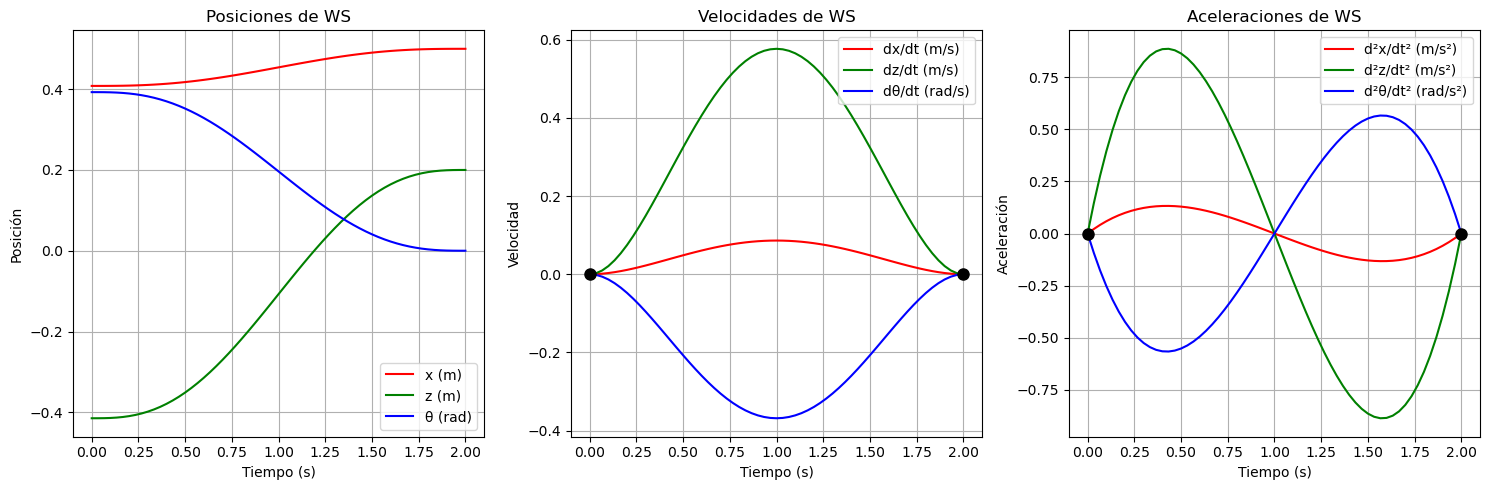

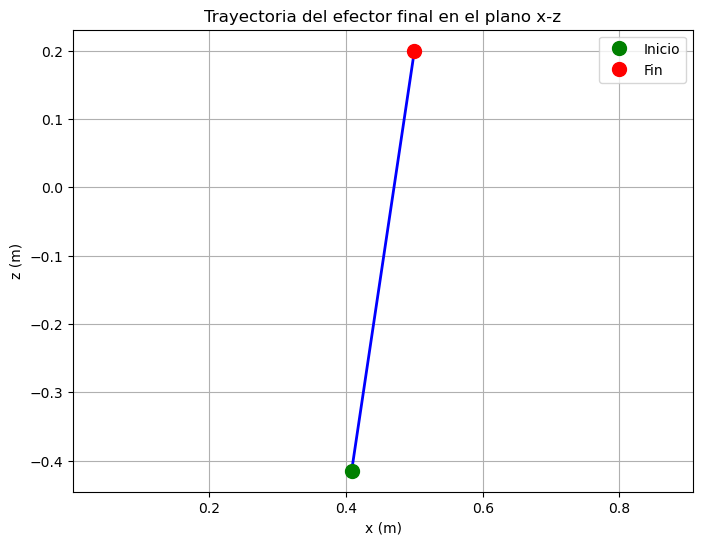

Posición inicial del efector: x=0.408, z=-0.415, θ=0.393
Posición final del efector: x=0.500, z=0.200, θ=0.000
Velocidades máximas: x=0.086 m/s, z=0.576 m/s, θ=0.368 rad/s
Aceleraciones máximas: x=0.133 m/s², z=0.887 m/s², θ=0.567 rad/s²

Ejemplo 2
Generando trayectoria suave
Polinomio de interpolación calculado
Muestreando trayectoria
Iteración 0
Iteración 10
Iteración 20
Iteración 30
Iteración 40
Iteración 50
Iteración 60
Iteración 70
Iteración 80
Iteración 90

Verificación de condiciones
Velocidad inicial: x'=0.000000, z'=0.000000, θ'=0.000000
Velocidad final: x'=0.000000, z'=0.000000, θ'=0.000000
Aceleración inicial: x''=0.000000, z''=0.000000, θ''=0.000000
Aceleración final: x''=0.000000, z''=0.000000, θ''=0.000000


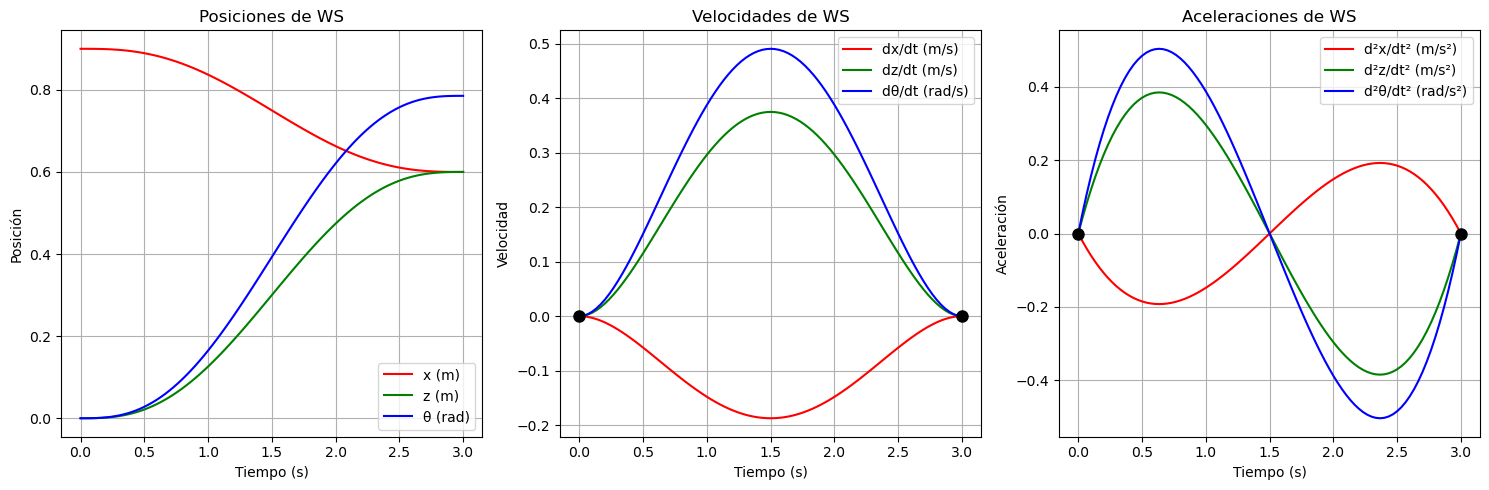

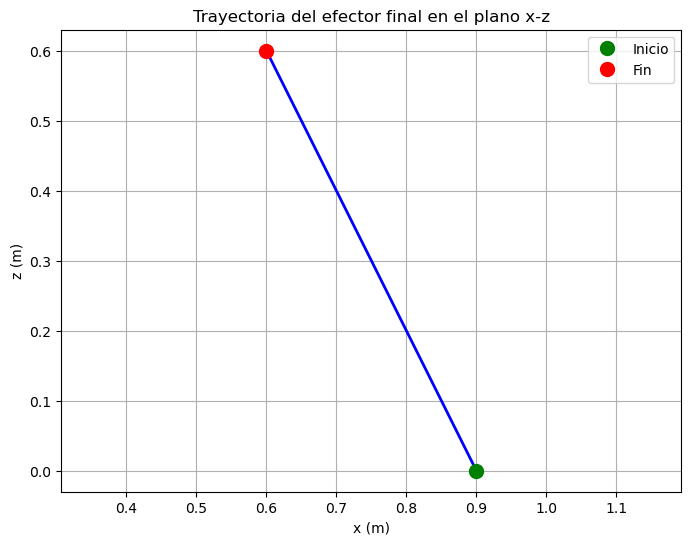

Posición inicial del efector: x=0.900, z=0.000, θ=0.000
Posición final del efector: x=0.600, z=0.600, θ=0.785
Velocidades máximas: x=0.187 m/s, z=0.375 m/s, θ=0.491 rad/s
Aceleraciones máximas: x=0.192 m/s², z=0.385 m/s², θ=0.504 rad/s²


In [24]:
# Colocar y correr el código dentro de estas celdas. 
# Agregar cuantas consideren conveniente
def generar_trayectoria_suave(q_inicial, xi_final, tiempo_total=2.0, frecuencia=30):
    """
    Genera una trayectoria suave con velocidades y aceleraciones nulas al inicio y final
    
    Parámetros:
    q_inicial: tupla con ángulos iniciales (θ1, θ2, θ3) en radianes
    xi_final: tupla con posición final del efector (x, z, θ) 
    tiempo_total: duración de la trayectoria en segundos
    frecuencia: muestras por segundo (Hz)
    """
    
    print("Generando trayectoria suave")
    
    # Variables para el tiempo y coeficientes del polinomio
    t = symbols('t')
    a0, a1, a2, a3, a4, a5 = symbols('a0 a1 a2 a3 a4 a5')
    
    # Polinomio de quinto grado para λ(t)
    # λ(t) = a0 + a1*t + a2*t² + a3*t³ + a4*t⁴ + a5*t⁵
    lam = a0 + a1*t + a2*t**2 + a3*t**3 + a4*t**4 + a5*t**5
    
    # Derivadas del polinomio
    lam_dot = diff(lam, t)      # Primera derivada
    lam_dot_dot = diff(lam_dot, t)  # Segunda derivada
    
    # Condiciones de contorno:
    # λ(0) = 0, λ(T) = 1
    # λ'(0) = 0, λ'(T) = 0 
    # λ''(0) = 0, λ''(T) = 0
    condiciones = [
        lam.subs(t, 0),                    # λ(0) = 0
        lam.subs(t, tiempo_total) - 1,     # λ(T) = 1
        lam_dot.subs(t, 0),                # λ'(0) = 0
        lam_dot.subs(t, tiempo_total),     # λ'(T) = 0
        lam_dot_dot.subs(t, 0),            # λ''(0) = 0
        lam_dot_dot.subs(t, tiempo_total)  # λ''(T) = 0
    ]
    
    # Resolver el sistema para obtener los coeficientes
    coeficientes = solve(condiciones, [a0, a1, a2, a3, a4, a5])
    
    # Sustituir los coeficientes en las expresiones
    lam_final = lam.subs(coeficientes)
    lam_dot_final = lam_dot.subs(coeficientes)
    lam_dot_dot_final = lam_dot_dot.subs(coeficientes)
    
    print("Polinomio de interpolación calculado")
    
    # Calcular posición inicial del efector final
    xi_inicial = xi.subs([(theta1, q_inicial[0]), (theta2, q_inicial[1]), (theta3, q_inicial[2])])
    
    # Trayectoria del efector final
    # Posición: ξ(t) = ξ_inicial + λ(t) * (ξ_final - ξ_inicial)
    x_traj = xi_inicial[0] + lam_final * (xi_final[0] - xi_inicial[0])
    z_traj = xi_inicial[1] + lam_final * (xi_final[1] - xi_inicial[1])
    theta_traj = xi_inicial[2] + lam_final * (xi_final[2] - xi_inicial[2])
    
    # Velocidad: ξ'(t) = λ'(t) * (ξ_final - ξ_inicial)
    x_dot_traj = lam_dot_final * (xi_final[0] - xi_inicial[0])
    z_dot_traj = lam_dot_final * (xi_final[1] - xi_inicial[1])
    theta_dot_traj = lam_dot_final * (xi_final[2] - xi_inicial[2])
    
    # Aceleración: ξ''(t) = λ''(t) * (ξ_final - ξ_inicial)
    x_ddot_traj = lam_dot_dot_final * (xi_final[0] - xi_inicial[0])
    z_ddot_traj = lam_dot_dot_final * (xi_final[1] - xi_inicial[1])
    theta_ddot_traj = lam_dot_dot_final * (xi_final[2] - xi_inicial[2])
    
    # Muestreo de la trayectoria
    n_muestras = int(frecuencia * tiempo_total + 1)
    dt = tiempo_total / (n_muestras - 1)
    
    # Arrays para almacenar los valores
    tiempo_vec = np.linspace(0, tiempo_total, n_muestras)
    
    # Convertir expresiones simbólicas a funciones numéricas
    x_func = lambdify(t, x_traj, 'numpy')
    z_func = lambdify(t, z_traj, 'numpy')
    theta_func = lambdify(t, theta_traj, 'numpy')
    
    x_dot_func = lambdify(t, x_dot_traj, 'numpy')
    z_dot_func = lambdify(t, z_dot_traj, 'numpy')
    theta_dot_func = lambdify(t, theta_dot_traj, 'numpy')
    
    x_ddot_func = lambdify(t, x_ddot_traj, 'numpy')
    z_ddot_func = lambdify(t, z_ddot_traj, 'numpy')
    theta_ddot_func = lambdify(t, theta_ddot_traj, 'numpy')
    
    # Evaluar las funciones con contador de iteraciones
    x_vals = x_func(tiempo_vec)
    z_vals = z_func(tiempo_vec)
    theta_vals = theta_func(tiempo_vec)
    
    x_dot_vals = x_dot_func(tiempo_vec)
    z_dot_vals = z_dot_func(tiempo_vec)
    theta_dot_vals = theta_dot_func(tiempo_vec)
    
    x_ddot_vals = x_ddot_func(tiempo_vec)
    z_ddot_vals = z_ddot_func(tiempo_vec)
    theta_ddot_vals = theta_ddot_func(tiempo_vec)
    
    # Mostrar progreso de iteraciones
    print("Muestreando trayectoria")
    for i in range(n_muestras):
        if i % 10 == 0 or i == n_muestras - 1:
            print(f"Iteración {i}")
    
    # Verificar condiciones iniciales y finales
    print("\nVerificación de condiciones")
    print(f"Velocidad inicial: x'={x_dot_vals[0]:.6f}, z'={z_dot_vals[0]:.6f}, θ'={theta_dot_vals[0]:.6f}")
    print(f"Velocidad final: x'={x_dot_vals[-1]:.6f}, z'={z_dot_vals[-1]:.6f}, θ'={theta_dot_vals[-1]:.6f}")
    print(f"Aceleración inicial: x''={x_ddot_vals[0]:.6f}, z''={z_ddot_vals[0]:.6f}, θ''={theta_ddot_vals[0]:.6f}")
    print(f"Aceleración final: x''={x_ddot_vals[-1]:.6f}, z''={z_ddot_vals[-1]:.6f}, θ''={theta_ddot_vals[-1]:.6f}")
    
    # Generar gráficas
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Gráfica de posición
    axes[0].set_title("Posiciones de WS")
    axes[0].plot(tiempo_vec, x_vals, color="RED", label='x (m)')
    axes[0].plot(tiempo_vec, z_vals, color="GREEN", label='z (m)')
    axes[0].plot(tiempo_vec, theta_vals, color="BLUE", label='θ (rad)')
    axes[0].set_xlabel('Tiempo (s)')
    axes[0].set_ylabel('Posición')
    axes[0].legend()
    axes[0].grid(True)
    
    # Gráfica de velocidad
    axes[1].set_title("Velocidades de WS")
    axes[1].plot(tiempo_vec, x_dot_vals, color="RED", label='dx/dt (m/s)')
    axes[1].plot(tiempo_vec, z_dot_vals, color="GREEN", label='dz/dt (m/s)')
    axes[1].plot(tiempo_vec, theta_dot_vals, color="BLUE", label='dθ/dt (rad/s)')
    axes[1].set_xlabel('Tiempo (s)')
    axes[1].set_ylabel('Velocidad')
    axes[1].legend()
    axes[1].grid(True)
    
    # Marcar puntos inicial y final con círculos negros
    axes[1].plot(tiempo_vec[0], 0, 'ko', markersize=8)
    axes[1].plot(tiempo_vec[-1], 0, 'ko', markersize=8)
    
    # Gráfica de aceleración
    axes[2].set_title("Aceleraciones de WS")
    axes[2].plot(tiempo_vec, x_ddot_vals, color="RED", label='d²x/dt² (m/s²)')
    axes[2].plot(tiempo_vec, z_ddot_vals, color="GREEN", label='d²z/dt² (m/s²)')
    axes[2].plot(tiempo_vec, theta_ddot_vals, color="BLUE", label='d²θ/dt² (rad/s²)')
    axes[2].set_xlabel('Tiempo (s)')
    axes[2].set_ylabel('Aceleración')
    axes[2].legend()
    axes[2].grid(True)
    
    # Marcar puntos inicial y final con círculos negros
    axes[2].plot(tiempo_vec[0], 0, 'ko', markersize=8)
    axes[2].plot(tiempo_vec[-1], 0, 'ko', markersize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Gráfica adicional: Trayectoria en el plano x-z
    plt.figure(figsize=(8, 6))
    plt.plot(x_vals, z_vals, 'b-', linewidth=2)
    plt.plot(x_vals[0], z_vals[0], 'go', markersize=10, label='Inicio')
    plt.plot(x_vals[-1], z_vals[-1], 'ro', markersize=10, label='Fin')
    plt.xlabel('x (m)')
    plt.ylabel('z (m)')
    plt.title('Trayectoria del efector final en el plano x-z')
    plt.grid(True)
    plt.legend()
    plt.axis('equal')
    plt.show()
    
    # Estadísticas finales (mantener intacto según solicitud)
    print("Posición inicial del efector: x={:.3f}, z={:.3f}, θ={:.3f}".format(float(xi_inicial[0]), float(xi_inicial[1]), float(xi_inicial[2])))
    print("Posición final del efector: x={:.3f}, z={:.3f}, θ={:.3f}".format(float(xi_final[0]), float(xi_final[1]), float(xi_final[2])))
    print("Velocidades máximas: x={:.3f} m/s, z={:.3f} m/s, θ={:.3f} rad/s".format(np.max(np.abs(x_dot_vals)), np.max(np.abs(z_dot_vals)), np.max(np.abs(theta_dot_vals))))
    print("Aceleraciones máximas: x={:.3f} m/s², z={:.3f} m/s², θ={:.3f} rad/s²".format(np.max(np.abs(x_ddot_vals)), np.max(np.abs(z_ddot_vals)), np.max(np.abs(theta_ddot_vals))))
    
    return {
        'tiempo': tiempo_vec,
        'posicion': (x_vals, z_vals, theta_vals),
        'velocidad': (x_dot_vals, z_dot_vals, theta_dot_vals),
        'aceleracion': (x_ddot_vals, z_ddot_vals, theta_ddot_vals),
        'xi_inicial': xi_inicial,
        'xi_final': xi_final
    }

# Ejemplo de uso
print("Ejemplo 1")
# Configuración inicial de las juntas
q_inicial = (pi/4, -pi/2, 3*pi/8)  # θ1=45°, θ2=-90°, θ3=67.5°

# Posición final deseada del efector
xi_final = (0.5, 0.2, 0)  # x=0.5m, z=0.2m, θ=0rad

# Generar trayectoria
resultado1 = generar_trayectoria_suave(q_inicial, xi_final, tiempo_total=2.0, frecuencia=30)

print("\nEjemplo 2")
# Otro ejemplo con parámetros diferentes
q_inicial2 = (0, 0, 0)  # Configuración inicial diferente
xi_final2 = (0.6, 0.6, pi/4)  # Posición final diferente

resultado2 = generar_trayectoria_suave(q_inicial2, xi_final2, tiempo_total=3.0, frecuencia=30)

### 3. Cinemática inversa
A partir del modelo de la cinemática directa, obtener la expresión e la cinemática inversa, que relacione las velocidades de las juntas del robot con la velocidad del efector final. Ya que el modelo de cinemática inversa sólo permite obtener velocidades, obtener también expresiones que permitan obtener la posición de las juntas y sus aceleraciones

In [25]:
# Colocar y correr el código dentro de estas celdas. 
# Agregar cuantas consideren conveniente

print("Calculando cinematica inversa")

# Variables para los valores de las velocidades del ws
x_0_P_dot, z_0_P_dot, theta_0_P_dot = symbols("x_0_P_dot z_0_P_dot theta_0_P_dot")

# Derivada del vector de postura en términos de las velocidades del efector final
# xi' = [x' z' th'] 
xi_dot = Matrix([[x_0_P_dot], [z_0_P_dot], [theta_0_P_dot]])

print("Vector de velocidades del espacio de trabajo:")
print(xi_dot)

# Jacobiano ya está calculado desde la primera celda
print("\nMatriz Jacobiana:")
print(J)

# Inversa del Jacobiano
J_inv = J.inv()
print("\nInversa del Jacobiano:")
print(simplify(J_inv))

# De la primera derivada, despejamos q': 
# xi' = J * q'
# q' = J-1 * xi'
q_dot = J_inv * xi_dot

print("\nVelocidades de las juntas:")
print("q_dot = J_inv * xi_dot =")
print(simplify(q_dot))

# Variables simbólicas para las velocidades de las juntas
theta1_dot, theta2_dot, theta3_dot = symbols('theta1_dot theta2_dot theta3_dot')

# Variables simbólicas para las aceleraciones del espacio de trabajo
x_0_P_dot_dot, z_0_P_dot_dot, theta_0_P_dot_dot = symbols('x_0_P_dot_dot z_0_P_dot_dot theta_0_P_dot_dot')

# Crear una función lambdify para evaluación eficiente
q_dot_func = lambdify([x_0_P_dot, z_0_P_dot, theta_0_P_dot, theta1, theta2, theta3], q_dot)

Calculando cinematica inversa
Vector de velocidades del espacio de trabajo:
Matrix([[x_0_P_dot], [z_0_P_dot], [theta_0_P_dot]])

Matriz Jacobiana:
Matrix([[-(0.3*cos(theta2) + 0.3*cos(theta2 + theta3) + 0.3)*sin(theta1), (-0.3*sin(theta2) - 0.3*sin(theta2 + theta3))*cos(theta1), -0.3*sin(theta2 + theta3)*cos(theta1)], [0, 0.3*cos(theta2) + 0.3*cos(theta2 + theta3), 0.3*cos(theta2 + theta3)], [1, 1, 1]])

Inversa del Jacobiano:
Matrix([[3.33333333333333*cos(theta2)/(sin(theta1)*sin(theta2)*sin(theta2 + theta3) - sin(theta1)*cos(theta2)**2 - sin(theta1)*cos(theta2) - sin(theta1 - theta3)), 3.33333333333333*sin(theta2)*cos(theta1)/(sin(theta1)*sin(theta2)*sin(theta2 + theta3) - sin(theta1)*cos(theta2)**2 - sin(theta1)*cos(theta2) - sin(theta1 - theta3)), 1.0*sin(theta3)*cos(theta1)/(sin(theta1)*sin(theta2)*sin(theta2 + theta3) - sin(theta1)*cos(theta2)**2 - sin(theta1)*cos(theta2) - sin(theta1 - theta3))], [3.33333333333333*cos(theta2 + theta3)/(sin(theta1)*sin(theta2)*sin(theta2 + theta3

### 4. Aplicación de la cinemática inversa
Finalmente, a partir de los puntos de la trayectoria y el modelo de cinemática inversa, obtener las posiciones, velocidades y aceleraciones de las juntas del robot, así como sus gráficas en función del tiempo

Aplicando cinemática inversa para obtener posiciones, velocidades y aceleraciones de las juntas
Generando trayectoria suave
Polinomio de interpolación calculado
Muestreando trayectoria
Iteración 0
Iteración 10
Iteración 20
Iteración 30
Iteración 40
Iteración 50
Iteración 60

Verificación de condiciones
Velocidad inicial: x'=0.000000, z'=0.000000, θ'=-0.000000
Velocidad final: x'=0.000000, z'=0.000000, θ'=-0.000000
Aceleración inicial: x''=0.000000, z''=0.000000, θ''=-0.000000
Aceleración final: x''=0.000000, z''=0.000000, θ''=-0.000000


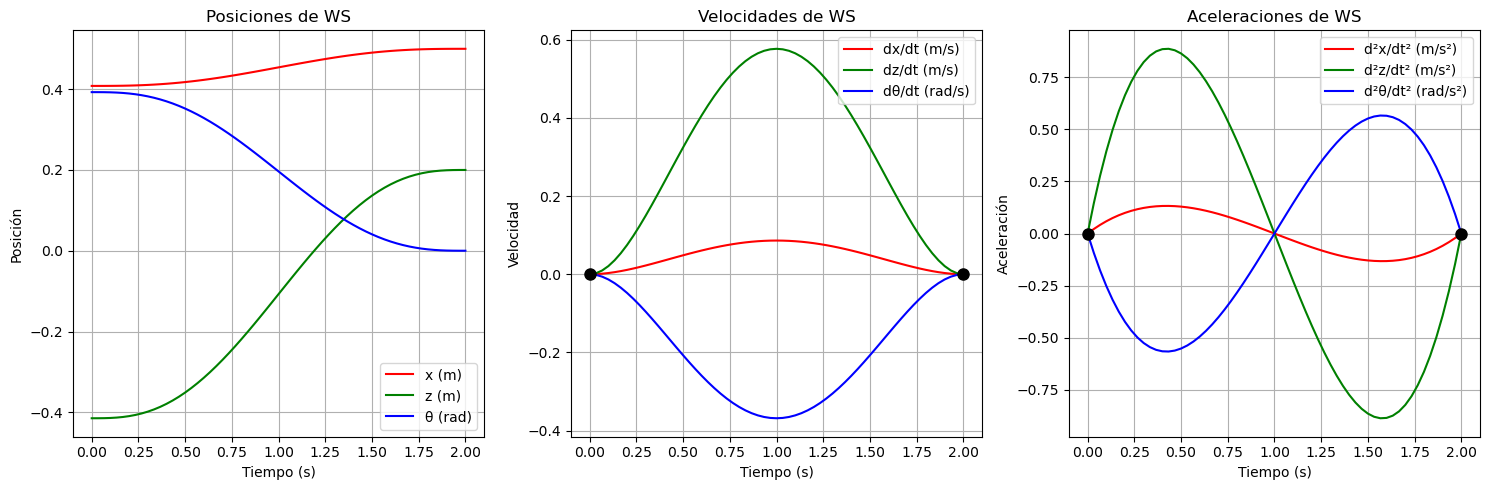

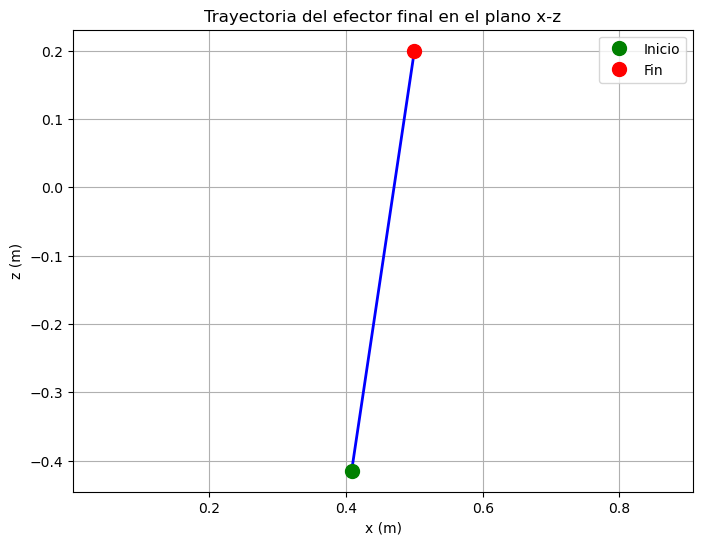

Posición inicial del efector: x=0.408, z=-0.415, θ=0.393
Posición final del efector: x=0.500, z=0.200, θ=0.000
Velocidades máximas: x=0.086 m/s, z=0.576 m/s, θ=0.368 rad/s
Aceleraciones máximas: x=0.133 m/s², z=0.887 m/s², θ=0.567 rad/s²
Calculando puntos
Iteración: 0
Iteración: 10
Iteración: 20
Iteración: 30
Iteración: 40
Iteración: 50
Iteración: 59
Calculando trayectoria del efector final


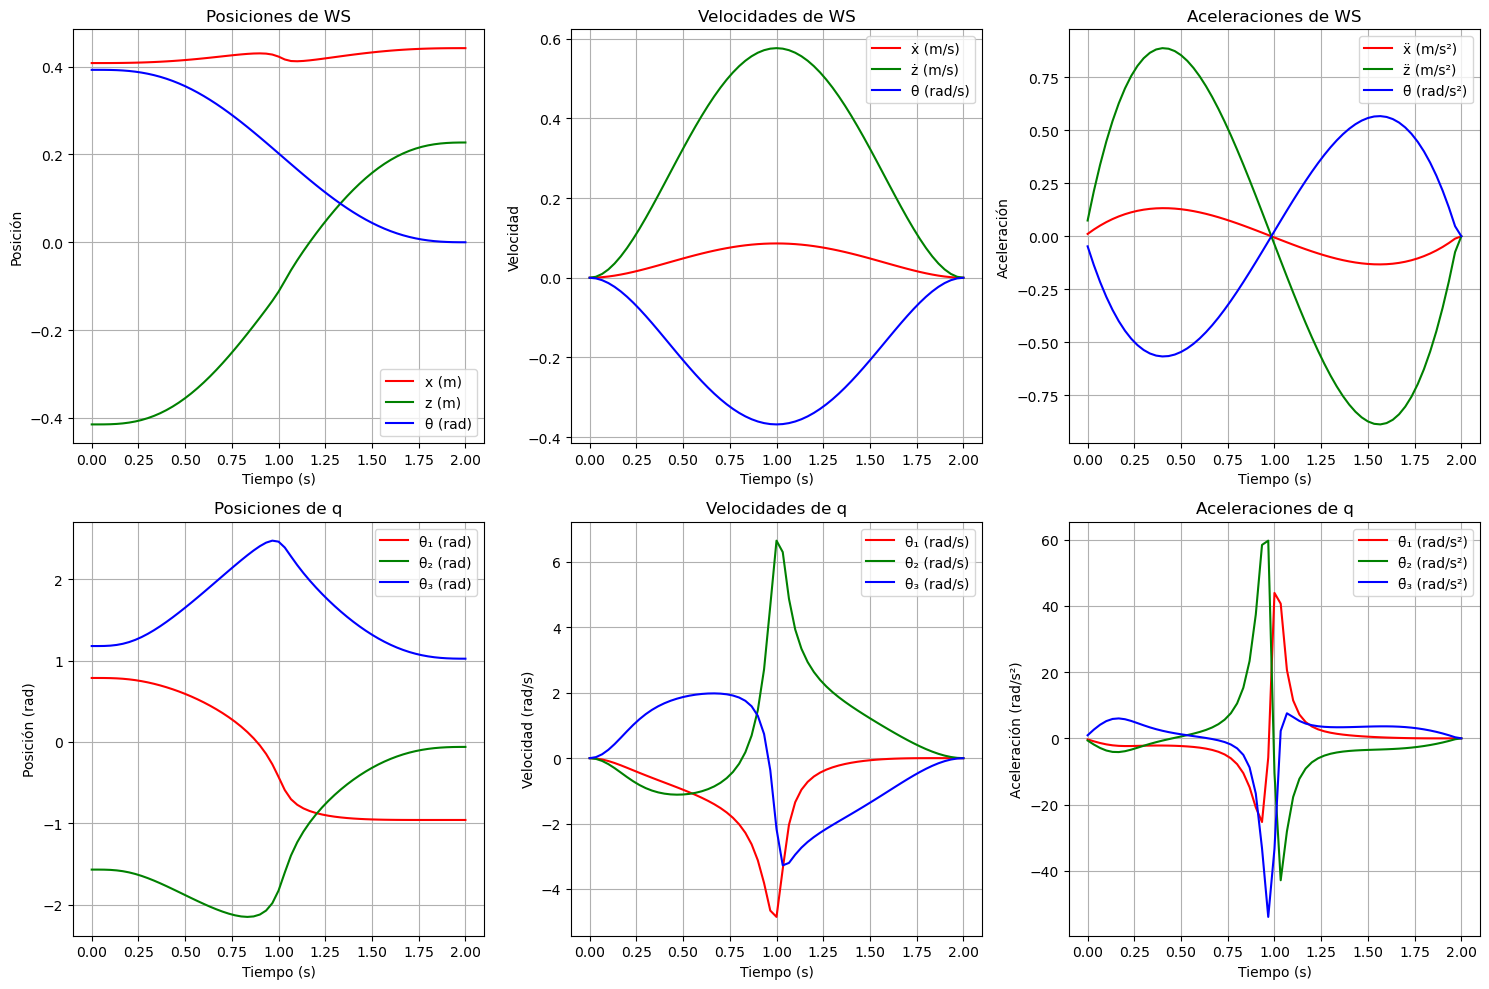

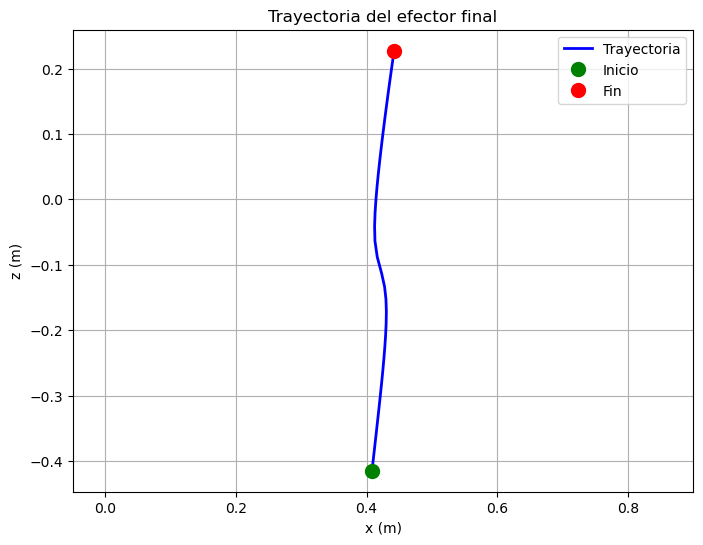


Verificación de resultados:
Posición inicial de las juntas: θ₁=0.785, θ₂=-1.571, θ₃=1.178 rad
Posición final de las juntas: θ₁=-0.960, θ₂=-0.062, θ₃=1.023 rad

Verificación con cinemática directa:
Posición deseada del efector: x=0.500, z=0.200, θ=0.000
Posición obtenida del efector: x=0.442, z=0.227, θ=0.000
Errores: Δx=0.057914 m, Δz=0.027218 m, Δθ=0.000000 rad


In [26]:
# Colocar y correr el código dentro de estas celdas. 
# Agregar cuantas consideren conveniente

print("Aplicando cinemática inversa para obtener posiciones, velocidades y aceleraciones de las juntas")

# Parámetros para la trayectoria
q_inicial = (pi/4, -pi/2, 3*pi/8)  # θ1=45°, θ2=-90°, θ3=67.5°
xi_final = (0.5, 0.2, 0)  # x=0.5m, z=0.2m, θ=0rad
tiempo_total = 2.0
frecuencia = 30

# Obtener la trayectoria del efector final generada anteriormente
resultado_trayectoria = generar_trayectoria_suave(q_inicial, xi_final, tiempo_total, frecuencia)

# Extraer los datos de la trayectoria
tiempo_vec = resultado_trayectoria['tiempo']
x_vals, z_vals, theta_vals = resultado_trayectoria['posicion']
x_dot_vals, z_dot_vals, theta_dot_vals = resultado_trayectoria['velocidad']
x_ddot_vals, z_ddot_vals, theta_ddot_vals = resultado_trayectoria['aceleracion']

# Número de muestras e incremento de tiempo
muestras = len(tiempo_vec)
dt = tiempo_total / (muestras - 1)

# Matrices vacías para los valores de espacio de las juntas
q_m = Matrix.zeros(3, muestras)
q_dot_m = Matrix.zeros(3, muestras)
q_dot_dot_m = Matrix.zeros(3, muestras)

# Agregando posición inicial (dato)
q_m[:, 0] = Matrix([[q_inicial[0]], [q_inicial[1]], [q_inicial[2]]])

# Agregando velocidad inicial
# q' = J-1 * xi' => Obtenemos velocidad de las juntas 
# en el punto actual sustituyendo velocidad actual del efector y 
# posición actual de las juntas
q_dot_m[:, 0] = q_dot_func(
    float(x_dot_vals[0]),
    float(z_dot_vals[0]),
    float(theta_dot_vals[0]),
    float(q_m[0, 0]),
    float(q_m[1, 0]),
    float(q_m[2, 0])
)

print("Calculando puntos")
for a in range(muestras - 1):
    # Posición de las juntas
    # Posición siguiente = posición actual + velocidad actual * dt 
    q_m[:, a+1] = q_m[:, a] + q_dot_m[:, a] * dt
    
    # Velocidad de las juntas 
    # Velocidad siguiente de las juntas a partir de velocidad siguiente del efector y posición siguiente de las juntas
    q_dot_m[:, a+1] = q_dot_func(
        float(x_dot_vals[a+1]),
        float(z_dot_vals[a+1]),
        float(theta_dot_vals[a+1]),
        float(q_m[0, a+1]),
        float(q_m[1, a+1]),
        float(q_m[2, a+1])
    )
    
    # Aceleración
    # Aceleración actual = velocidad siguiente - velocidad actual / dt
    q_dot_dot_m[:, a] = (q_dot_m[:, a+1] - q_dot_m[:, a]) / dt

    if a % 10 == 0 or a == muestras - 2:
        print("Iteración: " + str(a))

# Aceleración final (cero)
q_dot_dot_m[:, muestras - 1] = Matrix.zeros(3, 1)

# Verificar que el resultado es correcto aplicando cinemática directa al punto final
xi_final_calculado = xi.subs([
    (theta1, q_m[0, -1]), 
    (theta2, q_m[1, -1]), 
    (theta3, q_m[2, -1])
])

# Calcular trayectoria del efector final a partir de las juntas calculadas
xi_m = Matrix.zeros(3, muestras)
xi_dot_m = Matrix.zeros(3, muestras)
xi_dot_dot_m = Matrix.zeros(3, muestras)

print("Calculando trayectoria del efector final")
for i in range(muestras):
    # Posición
    xi_m[:, i] = xi.subs([
        (theta1, q_m[0, i]), 
        (theta2, q_m[1, i]), 
        (theta3, q_m[2, i])
    ])
    
    # Velocidad usando Jacobiano
    J_actual = J.subs([
        (theta1, q_m[0, i]), 
        (theta2, q_m[1, i]), 
        (theta3, q_m[2, i])
    ])
    xi_dot_m[:, i] = J_actual * Matrix([q_dot_m[0, i], q_dot_m[1, i], q_dot_m[2, i]])

# Aceleraciones por diferenciación numérica
for i in range(muestras - 1):
    xi_dot_dot_m[:, i] = (xi_dot_m[:, i+1] - xi_dot_m[:, i]) / dt
xi_dot_dot_m[:, muestras-1] = Matrix.zeros(3, 1)

# Graficar resultados
fig, ((xi_g, xi_dot_g, xi_dot_dot_g),
          (q_g, q_dot_g, q_dot_dot_g)) = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Posiciones ws
xi_g.set_title("Posiciones de WS")
xi_g.plot(tiempo_vec, np.array(xi_m[0, :].tolist(), dtype=float).flatten(), color="RED", label='x (m)')
xi_g.plot(tiempo_vec, np.array(xi_m[1, :].tolist(), dtype=float).flatten(), color="GREEN", label='z (m)')
xi_g.plot(tiempo_vec, np.array(xi_m[2, :].tolist(), dtype=float).flatten(), color="BLUE", label='θ (rad)')
xi_g.set_xlabel('Tiempo (s)')
xi_g.set_ylabel('Posición')
xi_g.legend()
xi_g.grid(True)

# Velocidades ws
xi_dot_g.set_title("Velocidades de WS")
xi_dot_g.plot(tiempo_vec, np.array(xi_dot_m[0, :].tolist(), dtype=float).flatten(), color="RED", label='ẋ (m/s)')
xi_dot_g.plot(tiempo_vec, np.array(xi_dot_m[1, :].tolist(), dtype=float).flatten(), color="GREEN", label='ż (m/s)')
xi_dot_g.plot(tiempo_vec, np.array(xi_dot_m[2, :].tolist(), dtype=float).flatten(), color="BLUE", label='θ̇ (rad/s)')
xi_dot_g.set_xlabel('Tiempo (s)')
xi_dot_g.set_ylabel('Velocidad')
xi_dot_g.legend()
xi_dot_g.grid(True)

# Aceleraciones ws
xi_dot_dot_g.set_title("Aceleraciones de WS")
xi_dot_dot_g.plot(tiempo_vec, np.array(xi_dot_dot_m[0, :].tolist(), dtype=float).flatten(), color="RED", label='ẍ (m/s²)')
xi_dot_dot_g.plot(tiempo_vec, np.array(xi_dot_dot_m[1, :].tolist(), dtype=float).flatten(), color="GREEN", label='z̈ (m/s²)')
xi_dot_dot_g.plot(tiempo_vec, np.array(xi_dot_dot_m[2, :].tolist(), dtype=float).flatten(), color="BLUE", label='θ̈ (rad/s²)')
xi_dot_dot_g.set_xlabel('Tiempo (s)')
xi_dot_dot_g.set_ylabel('Aceleración')
xi_dot_dot_g.legend()
xi_dot_dot_g.grid(True)

# Posiciones q
q_g.set_title("Posiciones de q")
q_g.plot(tiempo_vec, np.array(q_m[0, :].tolist(), dtype=float).flatten(), color="RED", label='θ₁ (rad)')
q_g.plot(tiempo_vec, np.array(q_m[1, :].tolist(), dtype=float).flatten(), color="GREEN", label='θ₂ (rad)')
q_g.plot(tiempo_vec, np.array(q_m[2, :].tolist(), dtype=float).flatten(), color="BLUE", label='θ₃ (rad)')
q_g.set_xlabel('Tiempo (s)')
q_g.set_ylabel('Posición (rad)')
q_g.legend()
q_g.grid(True)

# Velocidades q
q_dot_g.set_title("Velocidades de q")
q_dot_g.plot(tiempo_vec, np.array(q_dot_m[0, :].tolist(), dtype=float).flatten(), color="RED", label='θ̇₁ (rad/s)')
q_dot_g.plot(tiempo_vec, np.array(q_dot_m[1, :].tolist(), dtype=float).flatten(), color="GREEN", label='θ̇₂ (rad/s)')
q_dot_g.plot(tiempo_vec, np.array(q_dot_m[2, :].tolist(), dtype=float).flatten(), color="BLUE", label='θ̇₃ (rad/s)')
q_dot_g.set_xlabel('Tiempo (s)')
q_dot_g.set_ylabel('Velocidad (rad/s)')
q_dot_g.legend()
q_dot_g.grid(True)

# Aceleraciones q
q_dot_dot_g.set_title("Aceleraciones de q")
q_dot_dot_g.plot(tiempo_vec, np.array(q_dot_dot_m[0, :].tolist(), dtype=float).flatten(), color="RED", label='θ̈₁ (rad/s²)')
q_dot_dot_g.plot(tiempo_vec, np.array(q_dot_dot_m[1, :].tolist(), dtype=float).flatten(), color="GREEN", label='θ̈₂ (rad/s²)')
q_dot_dot_g.plot(tiempo_vec, np.array(q_dot_dot_m[2, :].tolist(), dtype=float).flatten(), color="BLUE", label='θ̈₃ (rad/s²)')
q_dot_dot_g.set_xlabel('Tiempo (s)')
q_dot_dot_g.set_ylabel('Aceleración (rad/s²)')
q_dot_dot_g.legend()
q_dot_dot_g.grid(True)

plt.tight_layout()
plt.show()

# Gráfica adicional de la trayectoria en el espacio de trabajo
plt.figure(figsize=(8, 6))
plt.plot(np.array(xi_m[0, :].tolist(), dtype=float).flatten(), 
         np.array(xi_m[1, :].tolist(), dtype=float).flatten(), 'b-', linewidth=2, label='Trayectoria')
plt.plot(float(xi_m[0, 0]), float(xi_m[1, 0]), 'go', markersize=10, label='Inicio')
plt.plot(float(xi_m[0, -1]), float(xi_m[1, -1]), 'ro', markersize=10, label='Fin')
plt.xlabel('x (m)')
plt.ylabel('z (m)')
plt.title('Trayectoria del efector final')
plt.grid(True)
plt.legend()
plt.axis('equal')
plt.show()

# Verificación de resultados
print("\nVerificación de resultados:")
print(f"Posición inicial de las juntas: θ₁={float(q_m[0, 0]):.3f}, θ₂={float(q_m[1, 0]):.3f}, θ₃={float(q_m[2, 0]):.3f} rad")
print(f"Posición final de las juntas: θ₁={float(q_m[0, -1]):.3f}, θ₂={float(q_m[1, -1]):.3f}, θ₃={float(q_m[2, -1]):.3f} rad")

print("\nVerificación con cinemática directa:")
print(f"Posición deseada del efector: x={xi_final[0]:.3f}, z={xi_final[1]:.3f}, θ={xi_final[2]:.3f}")
print(f"Posición obtenida del efector: x={float(xi_final_calculado[0]):.3f}, z={float(xi_final_calculado[1]):.3f}, θ={float(xi_final_calculado[2]):.3f}")

# Error entre posición deseada y obtenida
error_x = abs(xi_final[0] - float(xi_final_calculado[0]))
error_z = abs(xi_final[1] - float(xi_final_calculado[1]))
error_theta = abs(xi_final[2] - float(xi_final_calculado[2]))

print(f"Errores: Δx={error_x:.6f} m, Δz={error_z:.6f} m, Δθ={error_theta:.6f} rad")

### 5. Aplicación de la cinemática inversa
Para terminar, subir los archivos de la práctica al repositorio de github

## Análisis de resultados

- ¿Qué utilidad tiene el modelo de cinemática inversa de un robot?
> Que nos permite controlar la posición y orientación del efector final especificando dónde queremos que esté, en lugar de tener que calcular manualmente los ángulos de cada junta. Podemos planificar trayectorias suaves y precisas, y permite controlar en tiempo real que se adapte a cambios en el entorno.




## Conclusiones

> Implementamos un modelo cinemático directo e inverso de un robot RRR junto a las gráficas características de la posición, velocidad y aceleración de su efector final, confirmando que el modelo cinemático inverso es fundamental para la planificación de trayectorias suaves con condiciones iniciales y finales nulas. El análisis gráfico nos mostró la correspondencia entre las trayectorias deseadas y calculadas.

## Bibliografía 

[1] R. J. Schilling, *Fundamentals of Robotics: Analysis and Control*, 1st ed., Prentice Hall, 1990.

[2] J. J. Craig, *Introduction to Robotics: Mechanics and Control*, 3rd ed., Pearson Education, 2004.

[3] B. Siciliano and O. Khatib, *Springer Handbook of Robotics*, 2nd ed., Springer, 2016.

[4] M. W. Spong, S. Hutchinson, and M. Vidyasagar, *Robot Modeling and Control*, Wiley, 2006.


